# Single Cell Sequencing: Gynty's dataset comparison


In [1]:
### Reading Sharma, Ginty dataset
import numpy as np
import pandas as pd
import scanpy as sc
import csv
import anndata as ad

In [2]:
data_path = '/home/melma31/Documents/single_cell_sequencing/data/'
file_name = 'GSM4130750_WT_1.csv'

df_genes = []
df_cells = []
df_class = []
count_matrix = np.zeros((11139,20924))
with open(data_path+file_name, 'r') as file:
  csvreader = csv.reader(file)
  count  = 0
  for row in csvreader:
    if count == 0:
      df_class = row
    if count == 1:
      df_cells = row[1:]
    if count > 2:
      df_genes.append(row[0])
      x = [float(row[element]) for element in range(1, len(row))]
      count_matrix[:,count-3] = x
    count+=1

### generate anndata object
adata = ad.AnnData(count_matrix)
adata.obs_names = df_cells
adata.var_names = df_genes

/tmp/ipykernel_25402/1863787932.py:23: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(count_matrix)


In [3]:
adata.obs['class'] = df_class[1:]

(11139,)
(11139,)


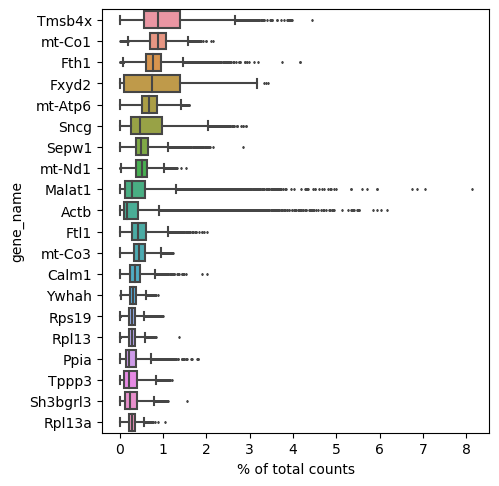

In [4]:
# Quality control - calculate QC covariates
adata.obs['n_counts'] = adata.X.sum(axis = 1)
x =  adata.X.sum(axis = 1)
adata.obs['log_counts'] = np.log(x)
adata.obs['n_genes'] = (adata.X > 0).sum(axis = 1)

adata.var_names_make_unique()
mt_gene_mask = np.flatnonzero([gene.startswith('mt-') for gene in adata.var_names])
# the `.A1` is only necessary as X is sparse (to transform to a dense array after summing)
y = np.sum(adata[:, mt_gene_mask].X, axis=1)
z = np.array(adata.obs['n_counts']).reshape(-1,)
print(y.shape)
print(z.shape)
adata.obs['mt_frac'] = y/z


adata.var["gene_name"] = df_genes
adata.var.index = adata.var["gene_name"]

adata.var_names_make_unique()

sc.pl.highest_expr_genes(adata, n_top=20)

adata.var["mt"] = adata.var_names.str.startswith("MT-")
sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"], inplace=True)

mito_genes = adata.var_names.str.startswith('mt-')
adata.obs['percent_mito'] = np.sum(
    adata[:, mito_genes].X, axis=1) / np.sum(adata.X, axis=1)

adata.obs['n_counts'] = adata.X.sum(axis=1)

In [5]:
print('Number of cells after min count filter: {:d}'.format(adata.n_obs))
sc.pp.filter_cells(adata, min_genes = 1000)
sc.pp.filter_cells(adata, min_genes = 1000)
sc.pp.filter_genes(adata, min_cells=5)
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, flavor='cell_ranger')
print('\n','Number of highly variable genes: {:d}'.format(np.sum(adata.var['highly_variable'])))

Number of cells after min count filter: 11139

 Number of highly variable genes: 3988


In [6]:
sc.pp.pca(adata, n_comps=25, use_highly_variable=True, svd_solver='arpack')
sc.pp.neighbors(adata)
sc.tl.tsne(adata) #Note n_jobs works for MulticoreTSNE, but not regular implementation)
sc.tl.umap(adata)
sc.tl.diffmap(adata)

2023-09-04 14:26:48.060345: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-04 14:26:48.151250: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-09-04 14:26:48.151266: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-09-04 14:26:48.668600: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

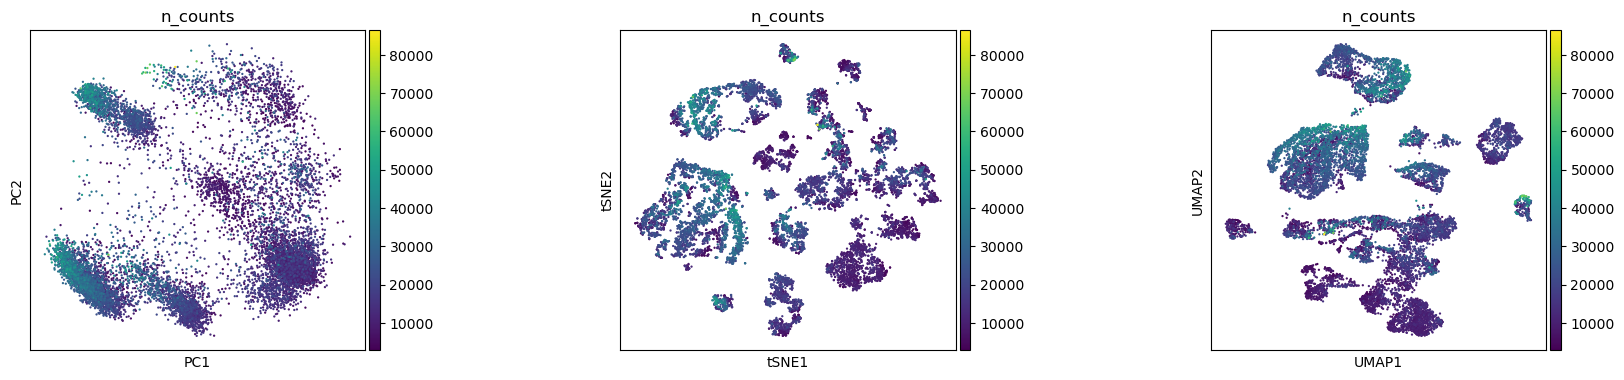

In [7]:
from matplotlib import rcParams
import matplotlib.pylab as plt


rcParams['figure.figsize']=(20,10)
fig_ind=np.arange(231, 237)
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.6)

p10 = sc.pl.pca_scatter(adata, color='n_counts', ax=fig.add_subplot(fig_ind[0]), show=False)
p11 = sc.pl.tsne(adata, color='n_counts', ax=fig.add_subplot(fig_ind[1]), show=False)
p12 = sc.pl.umap(adata, color='n_counts', ax=fig.add_subplot(fig_ind[2]), show=False)
plt.show()

## LOAD CAMPARI DATA

In [8]:
# load the unfiltered matrix and define all paths for storing data
figure_path = '/home/melma31/Documents/single_cell_sequencing/figures/'
results_file_sample1 = '/home/melma31/Documents/single_cell_sequencing/src/sample1/counts_unfiltered_umi/adata.h5ad'  # the file that will store the analysis results
results_file_sample2 = '/home/melma31/Documents/single_cell_sequencing/src/sample2/counts_unfiltered_umi/adata.h5ad'  # the file that will store the analysis results
results_file_sample3 = '/home/melma31/Documents/single_cell_sequencing/src/sample3/counts_unfiltered_umi/adata.h5ad'  # the file that will store the analysis results

#txt file with kept cells
cell_barcode_file_sample1 = '/home/melma31/Documents/single_cell_sequencing/SS3_22_291/zUMIs_output/SS3_22_291kept_barcodes.txt'
cell_barcode_file_sample2 = '/home/melma31/Documents/single_cell_sequencing/SS3_23_049/zUMIs_output/SS3_23_049kept_barcodes.txt'
cell_barcode_file_sample3 = '/home/melma31/Documents/single_cell_sequencing/SS3_23_127/zUMIs_output/SS3_23_127kept_barcodes.txt'

#read barcodes with kalisto
cell_barcode_file_new_sample1 = '/home/melma31/Documents/single_cell_sequencing/src/sample1/counts_unfiltered_umi/cells_x_genes.barcodes.txt'
cell_barcode_file_new_sample2 = '/home/melma31/Documents/single_cell_sequencing/src/sample2/counts_unfiltered_umi/cells_x_genes.barcodes.txt'
cell_barcode_file_new_sample3 = '/home/melma31/Documents/single_cell_sequencing/src/sample3/counts_unfiltered_umi/cells_x_genes.barcodes.txt'

#txt file with well barcodes. the text contains the cell barcode corresponding to each position in the plate
well_barcode_sample1 = '/home/melma31/Documents/single_cell_sequencing/SS3_22_291/zUMIs_output/stats/SS3_22_291.well_barcodes.txt'
well_barcode_sample2 = '/home/melma31/Documents/single_cell_sequencing/SS3_23_049/zUMIs_output/stats/SS3_23_049.well_barcodes.txt'
well_barcode_sample3 = '/home/melma31/Documents/single_cell_sequencing/SS3_23_127/zUMIs_output/stats/SS3_23_127.well_barcodes.txt'

###upload excel with red and green flourecence from campari (has information about position in plate and fluorecence level)
florecence_1_file_path = '/home/melma31/Documents/single_cell_sequencing/data/well_1_data_base.csv'
florecence_2_file_path = '/home/melma31/Documents/single_cell_sequencing/data/well_2_data_base.csv'
florecence_3_file_path = '/home/melma31/Documents/single_cell_sequencing/data/well_3_data_base.csv'

In [9]:
### load raw adata file using adata libraty
sample1 = ad.read_h5ad(results_file_sample1)
sample2 = ad.read_h5ad(results_file_sample2)
sample3 = ad.read_h5ad(results_file_sample3)

### read fluorecence levels
flourecence1 = pd.read_csv(florecence_1_file_path)
flourecence2 = pd.read_csv(florecence_2_file_path)
flourecence3 = pd.read_csv(florecence_3_file_path)

### read kept barcodes and barcodes provided by kalisto
df_1_sample1 = pd.read_csv(cell_barcode_file_sample1, delimiter = "\,")
df_2_sample1 = pd.read_csv(cell_barcode_file_new_sample1)

df_1_sample2 = pd.read_csv(cell_barcode_file_sample2, delimiter = "\,")
df_2_sample2 = pd.read_csv(cell_barcode_file_new_sample2)

df_1_sample3 = pd.read_csv(cell_barcode_file_sample3, delimiter = "\,")
df_2_sample3 = pd.read_csv(cell_barcode_file_new_sample3)

### merge data base. Merge information about cell barcode and fluorecence 
### (using as common demonimator the position in the plate)
barcode_list_sample1 = list(df_1_sample1['XC'])
well_df_sample1 = pd.read_csv(well_barcode_sample1, delimiter = "\t")
mergedRes1 = pd.merge(well_df_sample1 , flourecence1, on ='well_id')

barcode_list_sample2 = list(df_1_sample2['XC'])
well_df_sample2 = pd.read_csv(well_barcode_sample2, delimiter = "\t")
mergedRes2 = pd.merge(well_df_sample2 , flourecence2, on ='well_id')

barcode_list_sample3 = list(df_1_sample3['XC'])
well_df_sample3 = pd.read_csv(well_barcode_sample3, delimiter = "\t")
mergedRes3 = pd.merge(well_df_sample3 , flourecence3, on ='well_id')

/home/melma31/mambaforge/lib/python3.10/site-packages/pandas/util/_decorators.py:311: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  return func(*args, **kwargs)


In [10]:
def barcode_check(df_1,df_2,barcode_list,mergedRes):

    #print(barcode_list)
    kept_cells = np.zeros((len(df_1),))
    well_id = np.zeros((len(df_1),))

    red_f = np.zeros((len(df_1),))
    green_f = np.zeros((len(df_1),))
    stimulus = np.zeros((len(df_1),))

    index_vector = np.zeros((len(df_1),))
    count = 0
    counter = 0
    for i in range(len(df_2)):
        x = df_2.iloc[i]['Barcodes']
        if x in barcode_list:
            index = barcode_list.index(x)
            index_vector[count] = index
            if len(np.where(np.isnan(mergedRes['stimulus'].where(mergedRes['bc_set'] == x))==False)):
                counter+=1
                position = np.where(np.isnan(mergedRes['stimulus'].where(mergedRes['bc_set'] == x))==False)[0][0]
                stimulus[index] = mergedRes['stimulus'].where(mergedRes['bc_set'] == x)[position]
                red_f[index] = mergedRes['red_f'].where(mergedRes['bc_set'] == x)[position]
                green_f[index] = mergedRes['green_f'].where(mergedRes['bc_set'] == x)[position]
                kept_cells[index] = int(i)
                well_id[index] = 1
                count +=1
    #kept_cells = np.unique(kept_cells)
    count = len(df_1)
    
    return kept_cells, well_id,stimulus,red_f,green_f


In [11]:
kept_cells1, well_id1,stimulus_1,red_f1,green_f1 = barcode_check(df_1_sample1,df_2_sample1,barcode_list_sample1,mergedRes1)
kept_cells2, well_id2,stimulus_2,red_f2,green_f2 = barcode_check(df_1_sample2,df_2_sample2,barcode_list_sample2,mergedRes2)
kept_cells3, well_id3,stimulus_3,red_f3,green_f3 = barcode_check(df_1_sample3,df_2_sample3,barcode_list_sample3,mergedRes3)


In [12]:
### select only kept cells
adata1 = sample1[kept_cells1.astype(int),:]
adata2 = sample2[kept_cells2.astype(int),:]
adata3 = sample3[kept_cells3.astype(int),:]


### add campari information to adata structure
adata1.obs['stimulus'] = stimulus_1 
adata1.obs['red'] = red_f1
adata1.obs['green'] = green_f1
adata1.obs['well_id'] = well_id1

adata2.obs['stimulus'] = stimulus_2
adata2.obs['red'] = red_f2
adata2.obs['green'] = green_f2
adata2.obs['well_id'] = well_id2


adata3.obs['stimulus'] = stimulus_3
adata3.obs['red'] = red_f3
adata3.obs['green'] = green_f3
adata3.obs['well_id'] = well_id3


### data integration

adata_1 = adata1.concatenate(adata2, join='outer', batch_categories=['sample1', 'sample2'], index_unique='-')
adata_new = adata_1.concatenate(adata3, join='outer', batch_categories=['sample12', 'sample3'], index_unique='-')

print('Number of cells:', adata.X.shape[0])
print('Number of genes:', adata.X.shape[1])

/tmp/ipykernel_25402/1899569997.py:8: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata1.obs['stimulus'] = stimulus_1
/home/melma31/mambaforge/lib/python3.10/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/tmp/ipykernel_25402/1899569997.py:13: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata2.obs['stimulus'] = stimulus_2
/tmp/ipykernel_25402/1899569997.py:19: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata3.obs['stimulus'] = stimulus_3
/home/melma31/mambaforge/lib/python3.10/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly t

Number of cells: 11139
Number of genes: 17958


In [13]:
                           
# Filter cells according to identified QC thresholds:
print('Total number of cells: {:d}'.format(adata.n_obs))
sc.pp.filter_cells(adata_new, min_counts = 1000)
print('Number of cells after min count filter: {:d}'.format(adata_new.n_obs))
sc.pp.filter_cells(adata_new, min_genes = 1000)
#Filter genes:
print('Total number of genes: {:d}'.format(adata.n_vars))
# Min 20 cells - filters out 0 count genes
sc.pp.filter_genes(adata_new, min_cells=5)

# Min 20 cells - filters out 0 count genes
sc.pp.filter_genes(adata_new, min_cells=5)
sc.pp.normalize_total(adata_new, target_sum=1e4)

Total number of cells: 11139
Number of cells after min count filter: 1140
Total number of genes: 17958


In [14]:
# Quality control - calculate QC covariates
adata_new.obs['n_counts'] = adata_new.X.sum(axis = 1)
x =  adata_new.X.sum(axis = 1)
adata_new.obs['log_counts'] = np.log(x)
adata_new.obs['n_genes'] = (adata_new.X > 0).sum(axis = 1)
adata.var_names_make_unique()  # this is unnecessary if using `var_names='gene_ids'` in `sc.read_10x_mtx`
mt_gene_mask = np.flatnonzero([gene.startswith('mt-') for gene in adata.var_names])
# the `.A1` is only necessary as X is sparse (to transform to a dense array after summing)
y = np.sum(adata_new[:, mt_gene_mask].X, axis=1).A1.reshape(-1,)
z = np.array(adata_new.obs['n_counts']).reshape(-1,)
print(y.shape)
print(z.shape)

adata_new.obs['mt_frac'] = y/z
adata_new.var["gene_id"] = adata_new.var.index.values
t2g = pd.read_csv("t2g.txt", header=None, names=["tid", "gene_id", "gene_name"], sep="\t")
t2g.index = t2g.gene_id
t2g = t2g.loc[~t2g.index.duplicated(keep='first')]

adata_new.var["gene_name"] = adata_new.var.gene_id.map(t2g["gene_name"])
adata_new.var.index = adata_new.var["gene_name"]
adata_new.var_names_make_unique() 

adata_new.var["mt"] = adata_new.var_names.str.startswith("MT-")
sc.pp.calculate_qc_metrics(adata_new, qc_vars=["mt"], inplace=True)
                           

(1134,)
(1134,)


In [15]:
                           
# Filter cells according to identified QC thresholds:
print('Total number of cells: {:d}'.format(adata.n_obs))
sc.pp.filter_cells(adata_new, min_counts = 1000)
print('Number of cells after min count filter: {:d}'.format(adata_new.n_obs))
sc.pp.filter_cells(adata_new, min_genes = 1000)
#Filter genes:
print('Total number of genes: {:d}'.format(adata.n_vars))
# Min 20 cells - filters out 0 count genes
sc.pp.filter_genes(adata_new, min_cells=5)

# Min 20 cells - filters out 0 count genes
sc.pp.filter_genes(adata_new, min_cells=5)
sc.pp.normalize_total(adata_new, target_sum=1e4)

Total number of cells: 11139
Number of cells after min count filter: 1134
Total number of genes: 17958


In [16]:
var_genes_all = adata.var.highly_variable
print("Highly variable genes: %d"%sum(var_genes_all))

Highly variable genes: 3988


In [17]:
var_names = adata.var_names.intersection(adata_new.var_names)
adata = adata[:, var_names]
adata_new = adata_new[:, var_names]

In [18]:
sc.pp.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.tl.louvain(adata, resolution=1, key_added='louvain_1')

/home/melma31/mambaforge/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


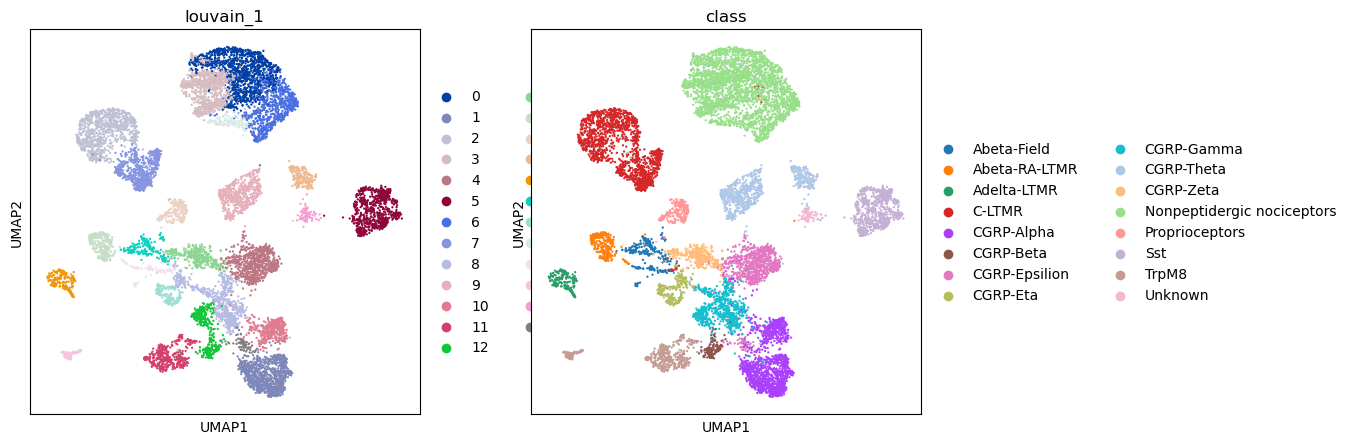

In [19]:
rcParams['figure.figsize']=(5,5)
sc.pl.umap(adata, color=['louvain_1','class'])

In [20]:
sc.tl.ingest(adata_new, adata, obs='class')

/home/melma31/mambaforge/lib/python3.10/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [36]:
def unique(list1):
 
    # initialize a null list
    unique_list = []
    # traverse for all elements
    for x in list1:
        # check if exists in unique_list or not
        if x not in unique_list:
            unique_list.append(x)
    return unique_list

unique_classes = unique(df_class)
fraction_cells = np.zeros((11,len(unique_classes)))

for i in range(11):
    
    index = np.logical_and(adata_new.obs['stimulus'] == i,adata_new.obs['red'] >= 0)
    aux_adata = adata_new[index,:]
    for j in range(len(aux_adata)):
        one_class = aux_adata.obs['class'][j]
        index = unique_classes.index(one_class)
        fraction_cells[i,index] +=1
    

In [37]:
fraction_cells = fraction_cells / np.sum(fraction_cells, axis = 1).reshape(-1,1)

17


NameError: name 'stim' is not defined

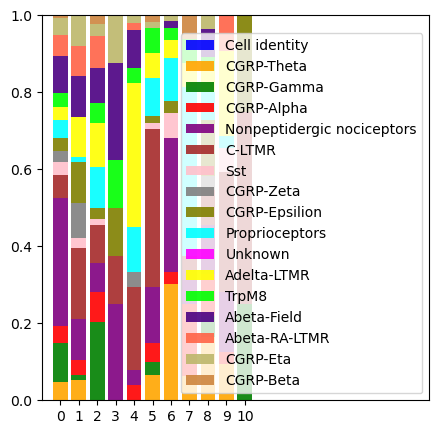

In [39]:
labels=['Control','pinch','new_stroke','ballon','AG','AD','heating','mock','old_stroke','anal_pinch','mock_w_poop','vaginal_distension','tomatoe','poop']

colors = ['blue','orange','green','red','purple','brown','pink','gray','olive','cyan','magenta','yellow',
          'lime','indigo','tomato','darkkhaki','peru']

#colors = ['gainsboro','green','darkorange','purple','magenta','cyan','red','orange','yellow','brown',
#         'orange','blue','violet','k']

print(len(unique_classes))
fig, axes = plt.subplots()
cumulative = fraction_cells[:,0] * 0
for i in range(len(unique_classes)):
    axes.bar(np.arange(0,11),fraction_cells[:,i], bottom = cumulative, color = colors[i],alpha = 0.9)
    cumulative = cumulative + fraction_cells[:,i]

axes.legend(unique_classes)
axes.set_ylim([0,1])
axes.set_xlim([-1,20])
axes.set_xticks(np.arange(0,11))
xticklabels = axes.set_xticklabels(stim)
axes.set_xticklabels(xticklabels, rotation = 90)

fig.set_size_inches([12,8])
fig.suptitle('Cell class type (Gynty dataset)', fontsize = 15)
fig.savefig(figure_path + 'classification.png')

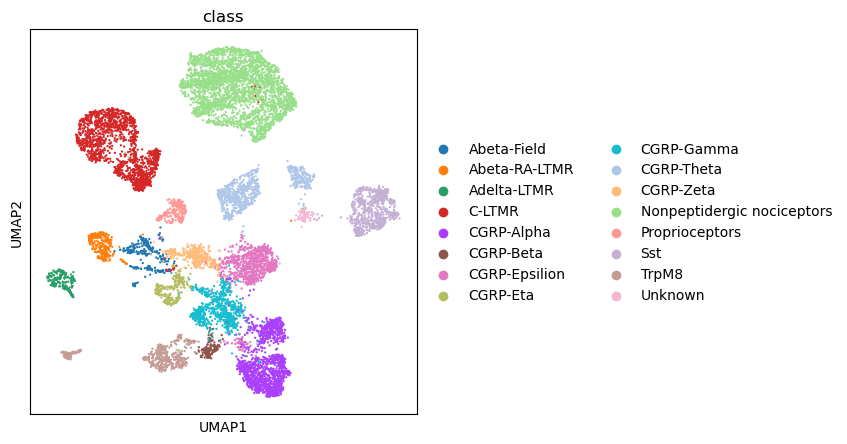

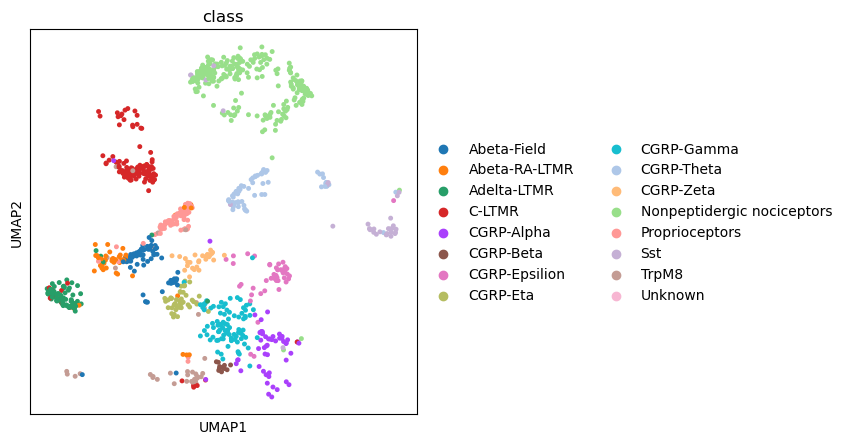

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(0, 16449)


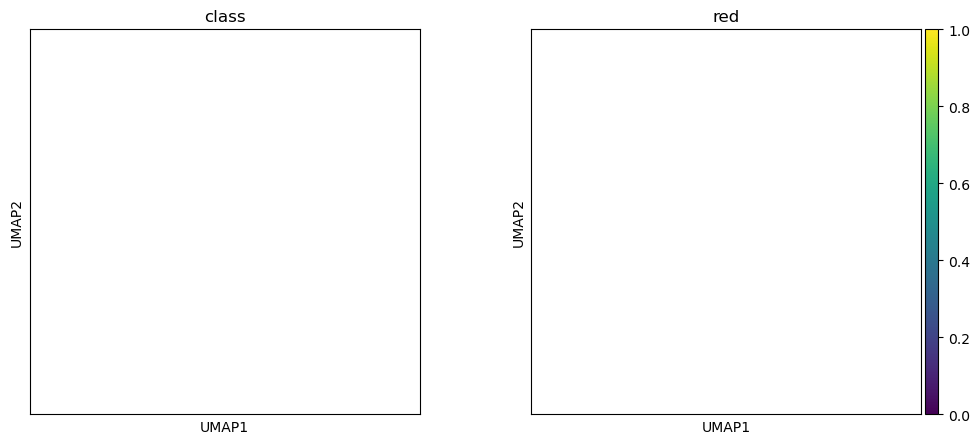

(71, 16449)


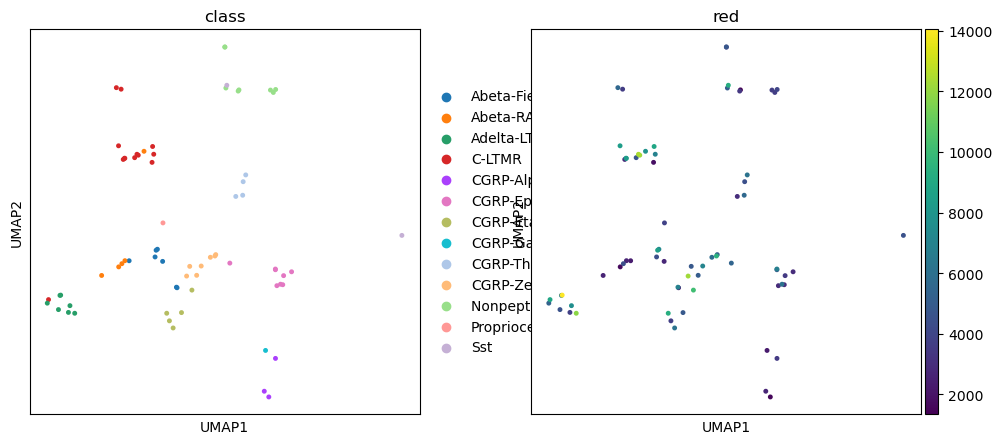

(127, 16449)


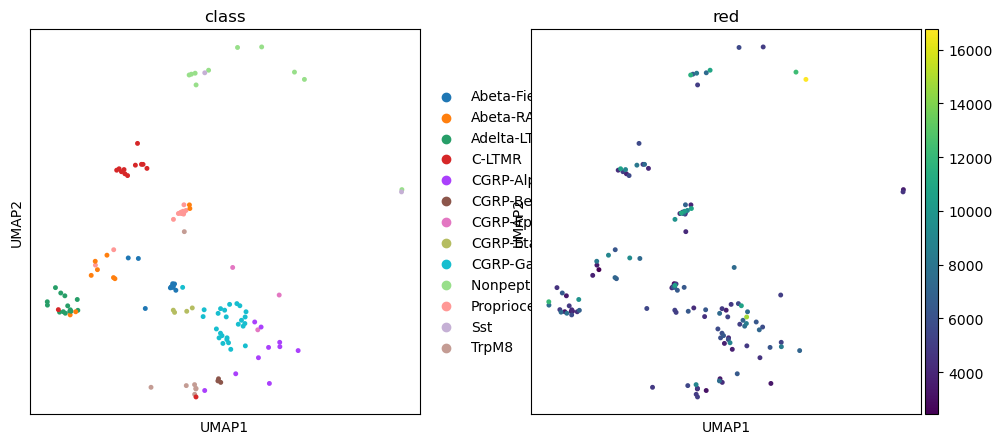

(8, 16449)


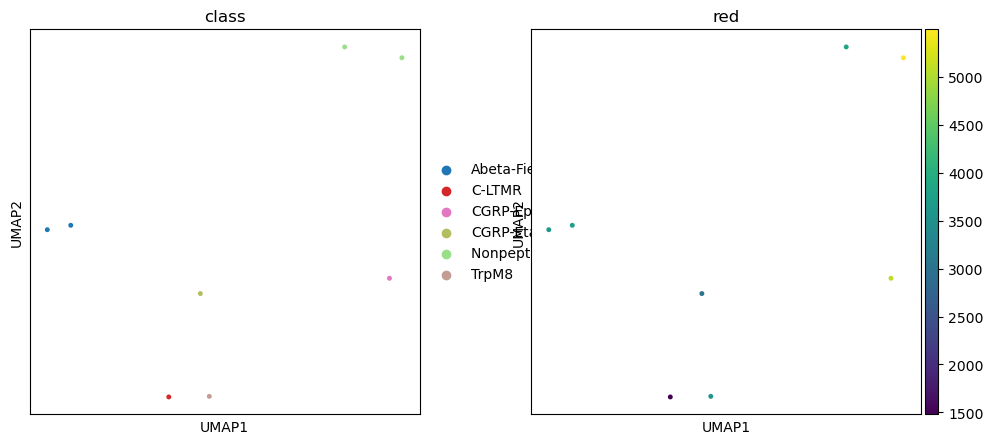

(50, 16449)


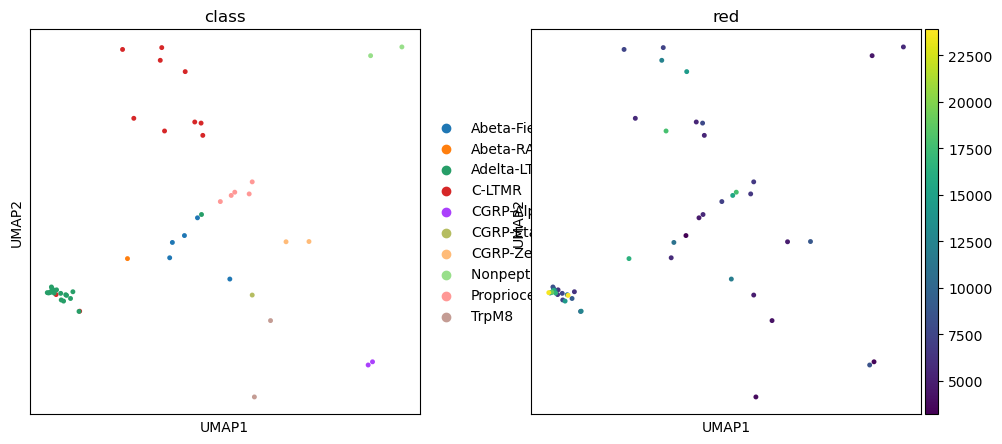

(58, 16449)


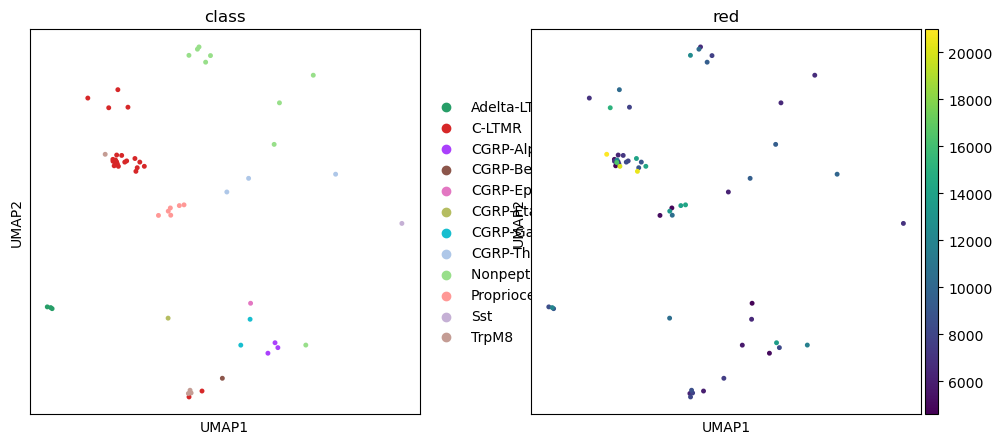

(63, 16449)


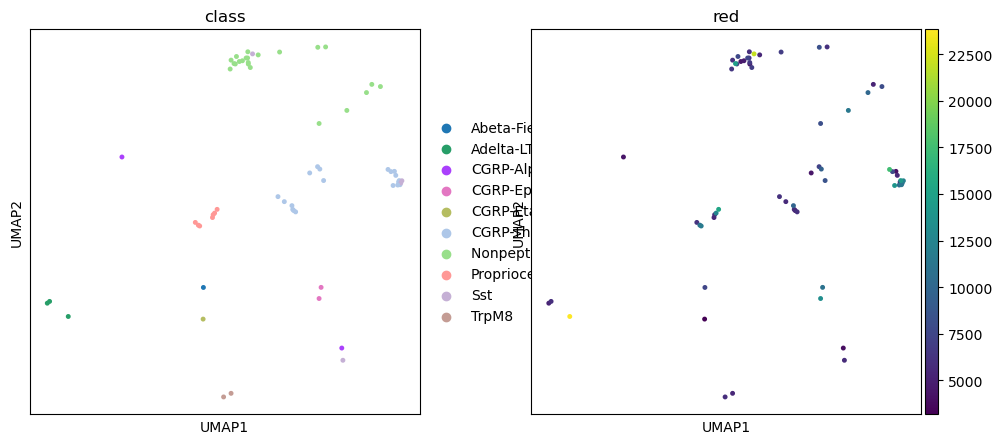

In [42]:
adata_concat = adata.concatenate(adata_new, batch_categories=['ref', 'new'])
sc.pl.umap(adata, color='class', save = 'ginty_clustering.png')
sc.pl.umap(adata_new, color='class',size = 50, wspace=1, save = 'UMIs/ginty_comparison/data_clustering_into_ginty.png')


labels=['Control','pinch','stroke','ballon','AG','AD','heating','mock']

for i in range(0,7):
    index = np.logical_and(adata_new.obs['stimulus'] == i,adata_new.obs['red'] > 0)
    aux_adata = adata_new[index,:]
    print(aux_adata.shape)
    sc.pl.umap(aux_adata, size = 50, color = ['class','red'],save = 'UMIs/ginty_comparison/stimulus_ginty_map_' + labels[i]+ '.png')
    #sc.pl.umap(aux_adata, size = 50, color = , color_map = 'Reds',save = 'stimulus_ginty_map_red_' + labels[i]+ '.png')



#sc.pl.umap(adata_new, color='stimulus', wspace=1)

/home/melma31/mambaforge/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


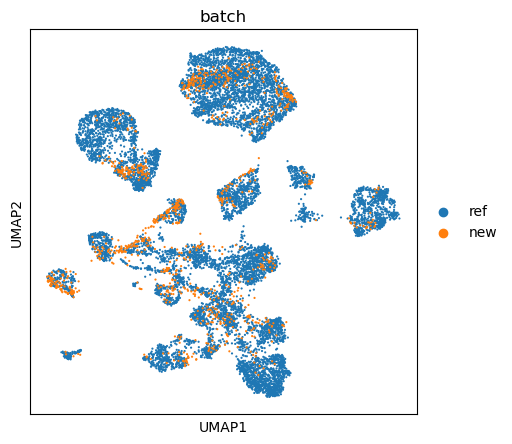

In [41]:
sc.pl.umap(adata_concat, color=['batch'], save = 'UMIs/ginty_comparison/ginty_us_overlap.png')
